# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


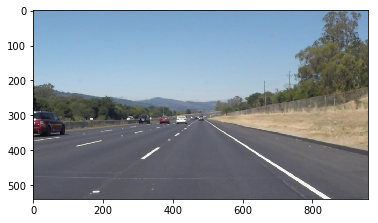

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
# Parameterized function for lane line detection
def process_image_v1(
    image,
    draw_siggestions = False,
    horizontal_filter = True,
    probabilistic_detector = True,
    average_matrix_size = 0,
    average_matrix = [],
    average_theta_dif = 3 * np.pi / 180,
    average_max_dist = 15,
    direction_line_thickness = 10,
    direction_line_color = (255, 0, 0),
    direction_line_weight = 0.6,
    region_top_rel_pos = ((5.0 ** 0.5) - 1.0) / 2.0,
    region_top_rel_width = 0.11,
    region_top_rel_shift = 0.01,
    blur_kernel_size = 5,
    blur_kernel_size_prob_detector = 3,
    canny_low_threshold = 50,
    canny_high_threshold = 150,
    hough_rho = 2,
    hough_theta = np.pi/180,
    hough_threshold = 25,
    hough_min_line_length = 40,
    hough_max_line_gap = 25,
    additional_contrast = False,
    additional_sobel_v_filter = False,
    additional_gaussian_before = False,
    additional_gaussian_after = False,
    additional_use_polyfit_segments = True):

    # Calc line paramiters (Theta, Rho) by line ends
    def calc_line_polar(x1, y1, x2, y2):
        lTheta = 0
        lRho = 0
        if (x1 != x2) or (y1 != y2):
            if x1 == x2:
                lTheta = 0
                lRho = abs(y2 - y1)
            elif y1 == y2:
                lTheta = np.pi / 2
                lRho = abs(x2 - x1)
            else:
                if (((x2 - x1) > 0) and ((y2 - y1) < 0)) or (((x2 - x1) < 0) and ((y2 - y1) > 0)):
                    lSign = 1
                else:
                    lSign = -1

                sin_sq = (x2-x1)**2 / ((x2-x1)**2 + (y2-y1)**2) #Theta sin ** 2
                sin_theta = lSign * (sin_sq ** 0.5) #Theta sin (signed)
                cos_theta = (1 - sin_sq) ** 0.5; #Theta cos (positive always)
                    
                lTheta = math.asin(sin_theta) #Theta (signed)
                lRho = x1 * cos_theta + y1 * sin_theta #Rho (distance from polar 0,0)
        return lTheta, lRho

    # Group lines detected by Hough transformation by angle and distance
    def create_local_average_matrix(lines):
        local_average_matrix = []

        if (type(lines) != type(None)) and (len(lines) > 0):
            for line in lines:
                for x1,y1,x2,y2 in line:
                    if horizontal_filter:
                        sign = 1
                        if (x1 == x2) or (y1 == y2):
                            continue
                        elif ((x1 - central_vert_pos) * (x2 - central_vert_pos)) < 0:
                            continue
                        elif ((y1 - central_hor_pos) * (y2 - central_hor_pos)) < 0:
                            continue
                        elif (x1 <= central_vert_pos) and (x2 <= central_vert_pos):
                            if (not(min_tan <= (-(x2-x1) / (y2-y1)) <= max_tan)):
                                continue
                            sign = 1
                        elif (x1 >= central_vert_pos) and (x2 >= central_vert_pos):
                            if (not(min_tan <= ((x2-x1) / (y2-y1)) <= max_tan)):
                                continue
                            sign = -1
                        else:
                            continue

                    theta, rho = calc_line_polar(x1, y1, x2, y2)
                    weight = (x2-x1)**2 + (y2-y1)**2

                    # Groupping line segments by angle and distance (distance = max distance between lines and ends of other lines segments)
                    local_average_matrix_len = len(local_average_matrix)
                    isFound = False
                    if local_average_matrix_len > 0:
                        cur_index = 0
                        while cur_index < local_average_matrix_len:
                            avg_group = local_average_matrix[cur_index]
                            cur_index += 1

                            avg_sgn, avg_cnt, avg_theta_sum, avg_weight = avg_group[0]

                            if (avg_sgn * sign) <= 0:
                                continue

                            avg_theta = avg_sgn * ((avg_theta_sum / avg_cnt) ** 0.5)

                            if abs(theta - avg_theta) > average_theta_dif:
                                continue

                            is_max_distance_ok = True;
                            for itheta, irho, ix1, iy1, ix2, iy2 in avg_group[1]:
                                max_distance = max(abs(x1 * math.cos(itheta) + y1 * math.sin(itheta) - irho), abs(x2 * math.cos(itheta) + y2 * math.sin(itheta) - irho))
                                if max_distance > average_max_dist:
                                    is_max_distance_ok = False
                                    break

                            if is_max_distance_ok:
                                isFound = True
                                avg_cnt += 1.0
                                avg_theta_sum += theta ** 2
                                avg_weight += weight
                                avg_group[0] = (avg_sgn, avg_cnt, avg_theta_sum, avg_weight)
                                avg_group[1] += [(theta, rho, x1, y1, x2, y2)]
                                local_average_matrix[cur_index - 1] = avg_group

                    if not isFound:
                        local_average_matrix += [[(sign, 1.0, theta ** 2, weight), [(theta, rho, x1, y1, x2, y2)]]]
        return local_average_matrix

    
    # Combine array of average lane lines from several previous stream frames
    def get_average_line_ends(average_matrix):
        matrix_len = len(average_matrix)
        nx1, ny1, nx2, ny2 = (0, 0, 0, 0)
        px1, py1, px2, py2 = (0, 0, 0, 0)

        if matrix_len == 1:
            for average_matrix_item in average_matrix:
                for average_matrix_item_line in average_matrix_item:
                    if len(average_matrix_item_line[1]) > 0:
                        if average_matrix_item_line[0] > 0:
                            px1, py1, px2, py2 = average_matrix_item_line[1]
                        else:
                            nx1, ny1, nx2, ny2 = average_matrix_item_line[1]
        elif matrix_len > 1:
            for sign in range(-1, 2, 2):
                fit_x = []
                fit_y = []

                avg_theta_sq = 0
                avg_cnt = 0

                for average_matrix_item in average_matrix:
                    for average_matrix_item_line in average_matrix_item:
                        if (len(average_matrix_item_line[1]) > 0) and ((sign * average_matrix_item_line[0]) > 0):
                            x1, y1, x2, y2 = average_matrix_item_line[1]
                            theta, rho = calc_line_polar(x1, y1, x2, y2)

                            avg_cnt += 1
                            avg_theta_sq += theta ** 2

                if avg_cnt > 0:
                    avg_theta = sign * ((avg_theta_sq / avg_cnt) ** 0.5)
                    for average_matrix_item in average_matrix:
                        for average_matrix_item_line in average_matrix_item:
                            if (len(average_matrix_item_line[1]) > 0) and ((sign * average_matrix_item_line[0]) > 0):
                                x1, y1, x2, y2 = average_matrix_item_line[1]
                                theta, rho = calc_line_polar(x1, y1, x2, y2)

                                if abs(theta - avg_theta) <= average_theta_dif:
                                    fit_x += [x1] + [x2]
                                    fit_y += [y1] + [y2]
            
                if (len(fit_x) > 0) and (len(fit_y) > 0):
                    avg_line = np.polyfit(fit_x, fit_y, 1)
                    if avg_line[0] != 0:
                        if sign > 0:
                            py1 = imheight
                            px1 = (py1 - avg_line[1]) / avg_line[0]
                            py2 = central_hor_pos
                            px2 = (py2 - avg_line[1]) / avg_line[0]
                        else:
                            ny1 = imheight
                            nx1 = (ny1 - avg_line[1]) / avg_line[0]
                            ny2 = central_hor_pos
                            nx2 = (ny2 - avg_line[1]) / avg_line[0]
        return [[-1, (nx1, ny1, nx2, ny2)], [1, (px1, py1, px2, py2)]]

    # Optimization of average matrix, remove spurious data to make average move smooth
    def average_matrix_optimization(average_matrix):
        if len(average_matrix) >= 3:
            for sign in range(-1, 2, 2):
                isChanged = True
                while isChanged:
                    isChanged = False

                    lagOneIndex = -1
                    lagOneIndex2 = -1
                    lagOneTheta = 0
                    lagZeroIndex = -1
                    lagZeroIndex2 = -1
                    lagZeroTheta = 0

                    curIdx = 0
                    for average_matrix_item in average_matrix:
                        curIdx2 = 0
                        for average_matrix_item_line in average_matrix_item:
                            if (len(average_matrix_item_line[1]) > 0) and ((sign * average_matrix_item_line[0]) > 0):
                                x1, y1, x2, y2 = average_matrix_item_line[1]
                                theta, rho = calc_line_polar(x1, y1, x2, y2)

                                if (lagOneIndex >= 0) and (lagZeroIndex >= 0):
                                    if (abs(lagOneTheta - theta) <= average_theta_dif) and ((abs(lagZeroTheta - theta) > average_theta_dif) or (abs(lagZeroTheta - lagOneTheta) > average_theta_dif)):
                                        average_matrix[lagZeroIndex][lagZeroIndex2][1] = ()
                                        isChanged = True

                                lagOneIndex = lagZeroIndex
                                lagOneIndex2 = lagZeroIndex2
                                lagOneTheta = lagZeroTheta

                                lagZeroIndex = curIdx
                                lagZeroIndex2 = curIdx2
                                lagZeroTheta = theta

                            curIdx2 += 1
                            if isChanged:
                                break;

                        curIdx += 1
                        if isChanged:
                            break;

    # For already gray-scaled images (just for test purpose)
    if image.shape[2] == 1:
        image = np.dstack((image, image, image))

    # Image shape
    imshape = image.shape
    imwidth = imshape[1]
    imheight = imshape[0]
    imdepth = imshape[2]

    # Cannot process images other than RGB
    if imdepth != 3:
        return image

    # Gaussian smoothing parameters
    if probabilistic_detector and (not additional_sobel_v_filter):
        blur_kernel_size_calc = blur_kernel_size_prob_detector
    else:
        blur_kernel_size_calc = blur_kernel_size

    # Grayscale the image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    #plt.imshow(gray, cmap="Greys_r")
    #plt.show()

    #  Optionally add more contrast to image
    if additional_contrast:
        gray = cv2.filter2D(gray, -1, np.array([[-1.0/9, -1.0/9, -1.0/9], [-1.0/9, 2.0 - 1.0/9, -1.0/9], [-1.0/9, -1.0/9, -1.0/9]]))

        #plt.imshow(gray, cmap="Greys_r")
        #plt.show()

    # Optionally smooth image before Sobel filter
    if additional_gaussian_before:
        gray = cv2.GaussianBlur(gray, (blur_kernel_size_calc, blur_kernel_size_calc), 0)

        #plt.imshow(gray, cmap="Greys_r")
        #plt.show()

    # Optionally combined left and right vertical Sobel filter
    if additional_sobel_v_filter:
        gray1 = cv2.filter2D(gray, -1, np.array([[-1.0, 0, 1.0], [-2.0, 0, 2.0], [-1.0, 0, 1.0]]))
        gray2 = cv2.filter2D(gray, -1, np.array([[1.0, 0, -1.0], [2.0, 0, -2.0], [1.0, 0, -1.0]]))
        gray = cv2.max(gray1, gray2)

        #plt.imshow(gray, cmap="Greys_r")
        #plt.show()

    # Optionally smooth image after Sobel filter
    if additional_gaussian_after:
        gray = cv2.GaussianBlur(gray, (blur_kernel_size_calc, blur_kernel_size_calc), 0)

    # Canny edge detection - main detection algorithm
    edges = cv2.Canny(gray, canny_low_threshold, canny_high_threshold)
    #plt.imshow(edges, cmap="Greys_r")
    #plt.show()

    # Calculate mask shape from image shapes and apply it on result of edge detector. Leave only area of interest
    mask = np.zeros_like(edges) 
    ignore_mask_color = 255
    vertices = np.array(
        [
            [
                (0, imheight),
                (int(imwidth * (1.0 - region_top_rel_width + region_top_rel_shift) / 2.0), int(imheight * region_top_rel_pos)),
                (int(imwidth * (1.0 + region_top_rel_width + region_top_rel_shift) / 2.0), int(imheight * region_top_rel_pos)),
                (imwidth, imheight)
            ]
        ],
        dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    #plt.imshow(masked_edges, cmap="Greys_r")
    #plt.show()

    # Run Hough on edge detected image - return array of line segments
    lines = cv2.HoughLinesP(
        masked_edges,
        hough_rho,
        hough_theta,
        hough_threshold,
        np.array([]),
        hough_min_line_length,
        hough_max_line_gap)

    # Calculate parameters of horizontal lines suppression - allow remove lines with incorrect position and angles (like lines on car hood or from side shades)
    min_tan = 0.2
    max_tan = 2.75
    central_vert_pos = imwidth * (1.0 + region_top_rel_shift) / 2.0
    central_hor_pos = imheight * region_top_rel_pos
    if horizontal_filter:
        triangle_height = imheight * (1.0 - region_top_rel_pos)
        reg_top_size = imwidth * region_top_rel_width
        reg_bottom_size = imwidth * (1.0 - region_top_rel_width) / 2.0
        min_tan = reg_top_size / triangle_height / 2.0
        max_tan = (reg_bottom_size + reg_top_size) / triangle_height

    # Prepare drawing
    line_image_mask = np.zeros_like(image)
    color_mask = np.zeros_like(image)
    color_mask[:] = direction_line_color

    # Probabilistic detector - advanced algorithm of lines detection
    if probabilistic_detector:
        # Group line segments detected by Hough transformation in groups by angle and distance
        local_average_matrix = create_local_average_matrix(lines)

        # Combine average lines from previous stream frames to help further algorithm
        combined_avg_lines = get_average_line_ends(average_matrix)
        
        # Calculate line parameters in polar system
        combined_avg_lines_polar = []
        for sign, (x1, y1, x2, y2) in combined_avg_lines:
            if (x1 != x2) or (y1 != y2):
                theta, rho = calc_line_polar(x1, y1, x2, y2)
                combined_avg_lines_polar += [[sign, (theta, rho)]]

        # Find 2 groups of line with higest weight - one line for left and one for right lane line detection
        # Weight function is sum of squared line segments in group divided by maximal distance to average lane line previously detected
        # Second part of weight calculation add more accuracy for lane line detection from video stream.
        detected_line_matrix = [[-1, -1, [], []], [1, -1, [], []]]
        detected_line_matrix_len = len(detected_line_matrix)
        local_average_matrix_len = len(local_average_matrix)
        if local_average_matrix_len > 0:
            cur_index = 0
            while (cur_index < local_average_matrix_len):
                avg_group = local_average_matrix[cur_index]
                cur_index += 1

                avg_sgn, avg_cnt, avg_theta_sum, avg_weight = avg_group[0]
                avg_dist = average_max_dist / 4.0 #Minimal distance included in calculations
                for sign, (itheta, irho) in combined_avg_lines_polar:
                    if (avg_sgn * sign) > 0:
                        avg_dist = average_max_dist / 4.0

                        for theta, rho, x1, y1, x2, y2 in avg_group[1]:
                            avg_dist = max(avg_dist, abs(x1 * math.cos(itheta) + y1 * math.sin(itheta) - irho), abs(x2 * math.cos(itheta) + y2 * math.sin(itheta) - irho))

                        break

                avg_weight /= avg_dist

                cur_det_line_idx = 0
                while (cur_det_line_idx < detected_line_matrix_len):
                    detected_line = detected_line_matrix[cur_det_line_idx]
                    cur_det_line_idx += 1

                    if (detected_line[0] * avg_sgn) > 0:
                        if avg_weight > detected_line[1]:
                            detected_line[1] = avg_weight
                            detected_line[2] = avg_group[1]
                            detected_line_matrix[cur_det_line_idx - 1] = detected_line

        # Extrapolate lane lines from group of segments
        cur_det_line_idx = 0
        while (cur_det_line_idx < detected_line_matrix_len):
            detected_line = detected_line_matrix[cur_det_line_idx]
            cur_det_line_idx += 1

            if (detected_line[1] >= 0):
                # Use OpenCV polyfit function
                if additional_use_polyfit_segments:
                    fit_x = []
                    fit_y = []
            
                    for theta, rho, x1, y1, x2, y2 in detected_line[2]:
                        fit_x += [x1] + [x2]
                        fit_y += [y1] + [y2]

                    avg_line = np.polyfit(fit_x, fit_y, 1)

                    if avg_line[0] != 0:
                        detected_line[3] = avg_line
                    else:
                        detected_line[1] = -1
                # Or use argorithm based on average angle and centered distance
                else:
                    avg_cnt = 0
                    avg_theta = 0

                    for theta, rho, x1, y1, x2, y2 in detected_line[2]:
                        avg_cnt += 1
                        avg_theta += theta

                    if avg_cnt > 0:
                        theta = avg_theta / avg_cnt

                        min_rho = 0
                        max_rho = 0
                        avg_cnt = 0
                        
                        for itheta, irho, x1, y1, x2, y2 in detected_line[2]:
                            dist1 = x1 * math.cos(theta) + y1 * math.sin(theta)
                            dist2 = x2 * math.cos(theta) + y2 * math.sin(theta)

                            if avg_cnt <= 0:
                                min_rho = min(dist1, dist2)
                                max_rho = max(dist1, dist2)
                            else:
                                min_rho = min(min_rho, dist1, dist2)
                                max_rho = max(max_rho, dist1, dist2)

                            avg_cnt += 1

                        rho = (min_rho + max_rho) / 2
                        detected_line[3] = (theta, rho)
                    else:
                        detected_line[1] = -1

                detected_line_matrix[cur_det_line_idx - 1] = detected_line

        # Remove oldes value if average stream matrix is full
        if average_matrix_size > 0:
            while len(average_matrix) >= average_matrix_size:
                del average_matrix[0]
        else:
            average_matrix = []

        # Add new set of values in stream average matrix
        average_matrix_item = [[-1, ()], [1, ()]]

        for detected_line in detected_line_matrix:
            if (detected_line[1] >= 0):
                if additional_use_polyfit_segments:
                    avg_line = detected_line[3]
                    y1 = imheight
                    x1 = (y1 - avg_line[1]) / avg_line[0]
                    y2 = central_hor_pos
                    x2 = (y2 - avg_line[1]) / avg_line[0]

                    if detected_line[0] < 0:
                        average_matrix_item[0] = [-1, (x1, y1, x2, y2)]
                    elif detected_line[0] > 0:
                        average_matrix_item[1] = [1, (x1, y1, x2, y2)]
                else:
                    theta, rho = detected_line[3]

                    cos_theta = math.cos(theta)
                    tan_theta = math.tan(theta)

                    y1 = imheight
                    x1 = (rho / cos_theta) - y1 * tan_theta
                    y2 = central_hor_pos
                    x2 = (rho / cos_theta) - y2 * tan_theta

                    if detected_line[0] < 0:
                        average_matrix_item[0] = [-1, (x1, y1, x2, y2)]
                    elif detected_line[0] > 0:
                        average_matrix_item[1] = [1, (x1, y1, x2, y2)]
        
        average_matrix += [average_matrix_item]

        # Optimize average matrix and calculate averaged lane lines including latest value
        average_matrix_optimization(average_matrix)
        combined_avg_lines = get_average_line_ends(average_matrix)

        # And finally draw it
        for sign, (x1, y1, x2, y2) in combined_avg_lines:
            if (x1 != 0) or (x2 != 0) or (y1 != 0) or (y2 != 0):
                cv2.line(line_image_mask, (int(x1), int(y1)), (int(x2), int(y2)), (255, 255, 255), direction_line_thickness)
    
    # Simple algorithm - just draw all found lines on image
    else:
        if (type(lines) != type(None)) and (len(lines) > 0):
            for line in lines:
                for x1,y1,x2,y2 in line:
                    if horizontal_filter:
                        if (x1 == x2) or (y1 == y2):
                            continue
                        elif ((x1 - central_vert_pos) * (x2 - central_vert_pos)) < 0:
                            continue
                        elif ((y1 - central_hor_pos) * (y2 - central_hor_pos)) < 0:
                            continue
                        elif (x1 <= central_vert_pos) and (x2 <= central_vert_pos):
                            if (not(min_tan <= (-(x2-x1) / (y2-y1)) <= max_tan)):
                                continue
                        elif (x1 >= central_vert_pos) and (x2 >= central_vert_pos):
                            if (not(min_tan <= ((x2-x1) / (y2-y1)) <= max_tan)):
                                continue
                        else:
                            continue

                    cv2.line(line_image_mask, (int(x1), int(y1)), (int(x2), int(y2)), (255, 255, 255), direction_line_thickness)

    # Combine matrix to display main lane lines suggestion half-transparent and not affect whole scene
    image_outside_mask = cv2.bitwise_and(image, ~line_image_mask)
    image_inside_mask = cv2.bitwise_and(image, line_image_mask)
    color_mask = cv2.bitwise_and(color_mask, line_image_mask)

    image_inside_mask = cv2.addWeighted(image_inside_mask, 1.0 - direction_line_weight, color_mask, direction_line_weight, 0)
    result_image = cv2.addWeighted(image_outside_mask, 1.0, image_inside_mask, 1.0, 0)

    # Optionally draw additional lines to make possible investigate what lines was detected by Hough transformation and how it was analyzed by probabilistic detector algorithm
    if draw_siggestions:
        cv2.polylines(result_image, vertices, True, (0, 0, 255), 1)

        if (type(lines) != type(None)) and (len(lines) > 0):
            for line in lines:
                for x1,y1,x2,y2 in line:
                    if horizontal_filter:
                        if (x1 == x2) or (y1 == y2):
                            continue
                        elif ((x1 - central_vert_pos) * (x2 - central_vert_pos)) < 0:
                            continue
                        elif ((y1 - central_hor_pos) * (y2 - central_hor_pos)) < 0:
                            continue
                        elif (x1 <= central_vert_pos) and (x2 <= central_vert_pos):
                            if (not(min_tan <= (-(x2-x1) / (y2-y1)) <= max_tan)):
                                continue
                        elif (x1 >= central_vert_pos) and (x2 >= central_vert_pos):
                            if (not(min_tan <= ((x2-x1) / (y2-y1)) <= max_tan)):
                                continue
                        else:
                            continue

                    cv2.line(result_image, (int(x1), int(y1)), (int(x2), int(y2)), (64, 64, 255), 1)

        if probabilistic_detector:
            for average_matrix_item_line in average_matrix_item:
                if len(average_matrix_item_line[1]) > 0:
                    x1,y1,x2,y2 = average_matrix_item_line[1]
                    cv2.line(result_image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 1)

    return result_image


Loading image solidWhiteCurve.jpg ...
Loaded image <class 'numpy.ndarray'> with dimensions (540, 960, 3).
Processing image solidWhiteCurve.jpg ...


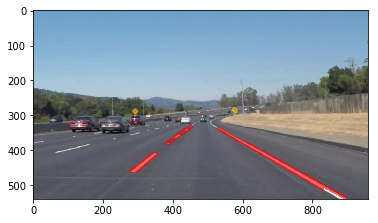

Loading image solidWhiteRight.jpg ...
Loaded image <class 'numpy.ndarray'> with dimensions (540, 960, 3).
Processing image solidWhiteRight.jpg ...


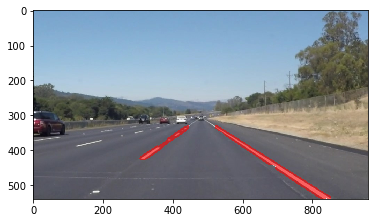

Loading image solidYellowCurve.jpg ...
Loaded image <class 'numpy.ndarray'> with dimensions (540, 960, 3).
Processing image solidYellowCurve.jpg ...


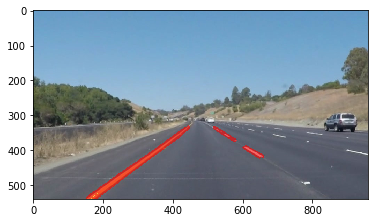

Loading image solidYellowCurve2.jpg ...
Loaded image <class 'numpy.ndarray'> with dimensions (540, 960, 3).
Processing image solidYellowCurve2.jpg ...


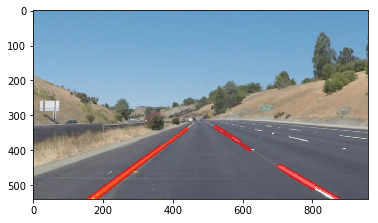

Loading image solidYellowLeft.jpg ...
Loaded image <class 'numpy.ndarray'> with dimensions (540, 960, 3).
Processing image solidYellowLeft.jpg ...


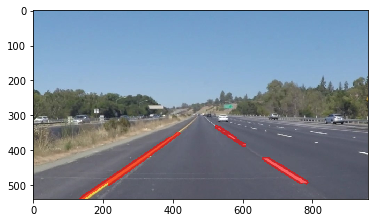

Loading image whiteCarLaneSwitch.jpg ...
Loaded image <class 'numpy.ndarray'> with dimensions (540, 960, 3).
Processing image whiteCarLaneSwitch.jpg ...


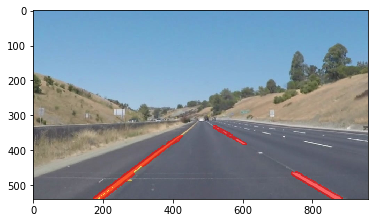

In [6]:
input_dir_path = "test_images/"
output_dir_path = "test_images_output/"

images_dir = None
try:
    images_dir = os.listdir(input_dir_path)
except:
    print("Cannot read list of images")

try:
    os.makedirs(output_dir_path)
except:
    pass

if type(images_dir) != type(None):
    for image_name in images_dir:
        try:
            image_path = input_dir_path + image_name
            if os.path.exists(image_path) and os.path.isfile(image_path) and (str(os.path.splitext(image_path)[1]).upper() in ('.JPG')):
                print("Loading image {0} ...".format(image_name))
                image = mpimg.imread(image_path)
                print('Loaded image {0} with dimensions {1}.'.format(type(image), image.shape))

                print("Processing image {0} ...".format(image_name))
                res_image = process_image_v1(image, probabilistic_detector = False)
                mpimg.imsave(output_dir_path + image_name, res_image)
                plt.imshow(res_image)
                plt.show()
        except:
            print("Image {0} cannot be processed.".format(image_name))


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image_simple(image):
    result = process_image_v1(
        image,
        average_matrix_size = 12,
        average_matrix = avg_matrix_global,
        probabilistic_detector = False)

    return result

Let's try the one with the solid white lane on the right first ...

In [9]:
global avg_matrix_global
avg_matrix_global = []

output_dir_path = 'test_videos_output/'
try:
    os.makedirs(output_dir_path)
except:
    pass

white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image_simple) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 221/222 [00:03<00:00, 59.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 4.14 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [14]:
def process_image(image):
    result = process_image_v1(
        image,
        average_matrix_size = 12,
        average_matrix = avg_matrix_global)

    return result

In [15]:
global avg_matrix_global
avg_matrix_global = []

output_dir_path = 'test_videos_output/'
try:
    os.makedirs(output_dir_path)
except:
    pass

yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 681/682 [00:12<00:00, 56.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 12.6 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [17]:
global avg_matrix_global
avg_matrix_global = []

output_dir_path = 'test_videos_output/'
try:
    os.makedirs(output_dir_path)
except:
    pass

challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 26.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 10.2 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))